In [4]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import os
from pmdarima import auto_arima
import joblib  # For saving the model

In [5]:
def get_csvs_from_dir(directory):
    try:
        datasets_dir = os.path.join(directory, 'environment', 'datasets')
        csv_files = [os.path.join(datasets_dir, file) for file in os.listdir(datasets_dir) if file.endswith('.csv')]
        stock_names = [file.split("\\")[-1].split(".")[0] for file in csv_files]
        return csv_files, stock_names
    except FileNotFoundError:
        print(f"The directory {datasets_dir} does not exist.")
        return [], []

def load_data(file_path):
    df = pd.read_csv(file_path)
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
    df.set_index('datetime', inplace=True)
    df = df['close'].resample('D').mean()
    df.interpolate(method='linear', inplace=True)
    return df


def train_or_load_model(df, model_path):
    train = df['2002-01-01':'2015-12-31']
    test = df['2016-01-01':'2018-12-31']
    if os.path.exists(model_path):
        model = joblib.load(model_path)
        print(f'Model loaded from {model_path}')
    else:
        model = auto_arima(train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
        print(f'Best ARIMA model: {model.order}')
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        joblib.dump(model, model_path)
        print(f'Model saved to {model_path}')
        
    return model, train, test

def perform_forecasting(model, train, test, model_path):
    predictions = []
    history = train.copy()  # Start with the training data as history

    for t in test.index:
        model = joblib.load(model_path)  # Load the model
        model.update(test[t:t])  # Update the model with the latest available data
        forecast = model.predict(n_periods=1)
        predictions.append(forecast[0])
        history = pd.concat([history, test[t:t]])
        
    return test, predictions


def save_predictions(test, predictions, results_dir):
    results_path = os.path.join(results_dir, 'predictions.csv')
    if os.path.exists(results_path):
        results_df = pd.read_csv(results_path)
        results_df['arima'] = predictions
    else:
        os.makedirs(os.path.dirname(results_path), exist_ok=True)
        results_df = pd.DataFrame({'date': test.index, 'actual': test.values, 'arima': predictions})
    results_df.to_csv(results_path, index=False)
    print(f"Predictions and actual prices updated in {results_path}")


def plot_results(test, predictions):
    plt.figure(figsize=(14, 7))
    plt.plot(test, label='Actual')
    plt.plot(test.index, predictions, color='red', linestyle='--', label='Forecast')
    plt.title('Rolling Forecast AutoARIMA Model with Stationarity Checks')
    plt.xlabel('Date')
    plt.ylabel('Daily Close Price')
    plt.legend()
    plt.show()

Processing a...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3636.153, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3716.198, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3630.197, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3631.785, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3715.021, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3632.189, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3632.189, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3634.192, Time=0.52 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3628.836, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3630.826, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3630.826, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3630.447, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3632.829, Time=0.37 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.592 seconds
Best A

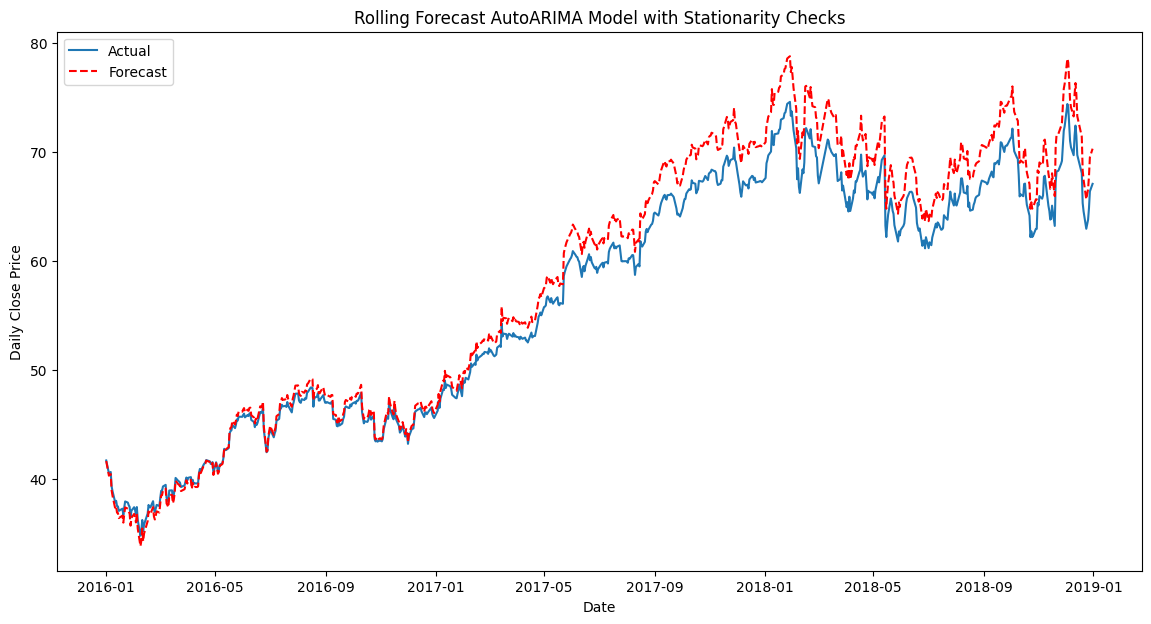

Processing aapl...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7954.453, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8273.796, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7953.000, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7964.456, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8280.804, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7954.885, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7954.847, Time=0.47 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7955.080, Time=1.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=7956.407, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 3.083 seconds
Best ARIMA model: (1, 1, 0)
Model saved to d:\Personal_Folders\Tocho\UMD\spring_2024\CMSC421\cmsc421_final_project\agents\trained_models\aapl\arima_model.pkl
Predictions and actual prices updated in d:\Personal_Folders\Tocho\UMD\spring_2024\CMSC421\cmsc421_final_proj

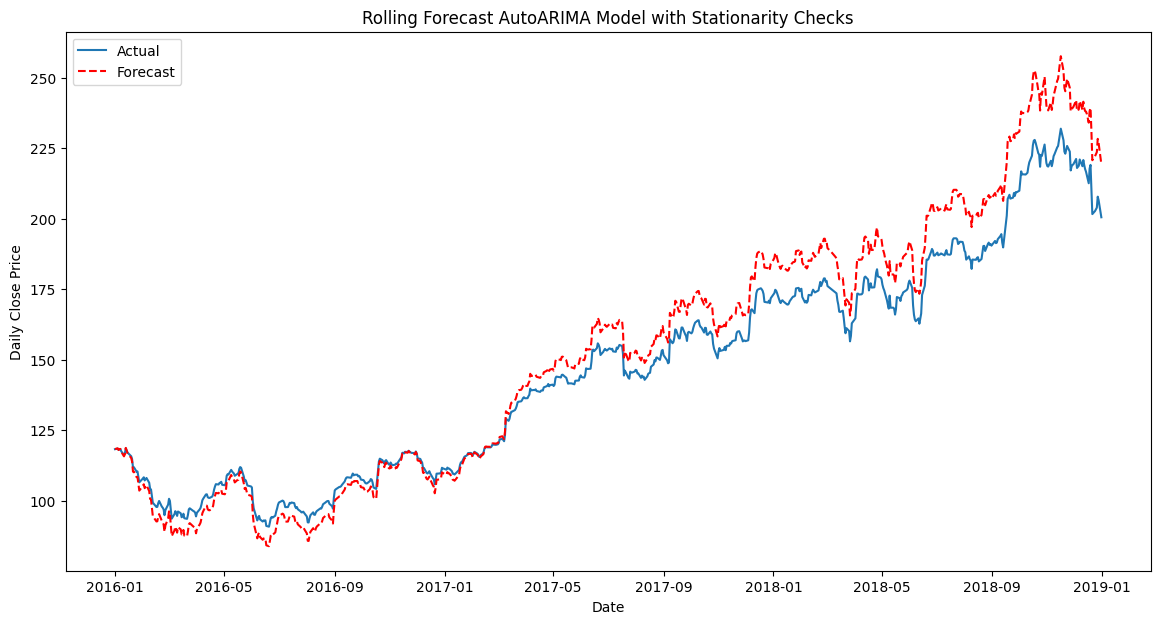

In [6]:
def process_stocks(project_dir):
    datasets, stock_names = get_csvs_from_dir(project_dir)
    for file_path, stock_name in zip(datasets, stock_names):
        print(f"Processing {stock_name}...")
        results_dir = os.path.join(project_dir, 'agents', 'trained_models', stock_name)
        df = load_data(file_path)
        model_path = os.path.join(results_dir, 'arima_model.pkl')
        
        # Load or train a model, and get the train and test datasets
        model, train, test = train_or_load_model(df, model_path)
        
        # Perform forecasting
        test, predictions = perform_forecasting(model, train, test, model_path)
        
        # Save the forecast predictions
        save_predictions(test, predictions, results_dir)
        
        # Plot the results
        plot_results(test, predictions)

if __name__ == '__main__':
    project_dir = os.path.dirname(os.path.dirname(os.getcwd()))
    process_stocks(project_dir)